# First attempt at a solution, problem statement below

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
<div>
<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png", width="200"/>
</div>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from spellchecker import SpellChecker
import spacy
import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime

import nltk.corpus
#nltk.download('stopwords')
#from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
nltk.download('punkt')


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.backend import clear_session
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model



%matplotlib inline
pd.set_option('max.column', 100)
pd.set_option('max.row', 100)
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 15,8
pd.set_option('display.max_colwidth', None)
sns.set()
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## import data

In [256]:
df = pd.read_csv(r'../data/train.csv')
test_o = pd.read_csv(r'../data/test.csv')


full = pd.concat([df, test_o])
df.shape, test.shape, full.shape

((7613, 5), (3263, 32), (10876, 5))

In [105]:
df.isnull().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

<AxesSubplot:>

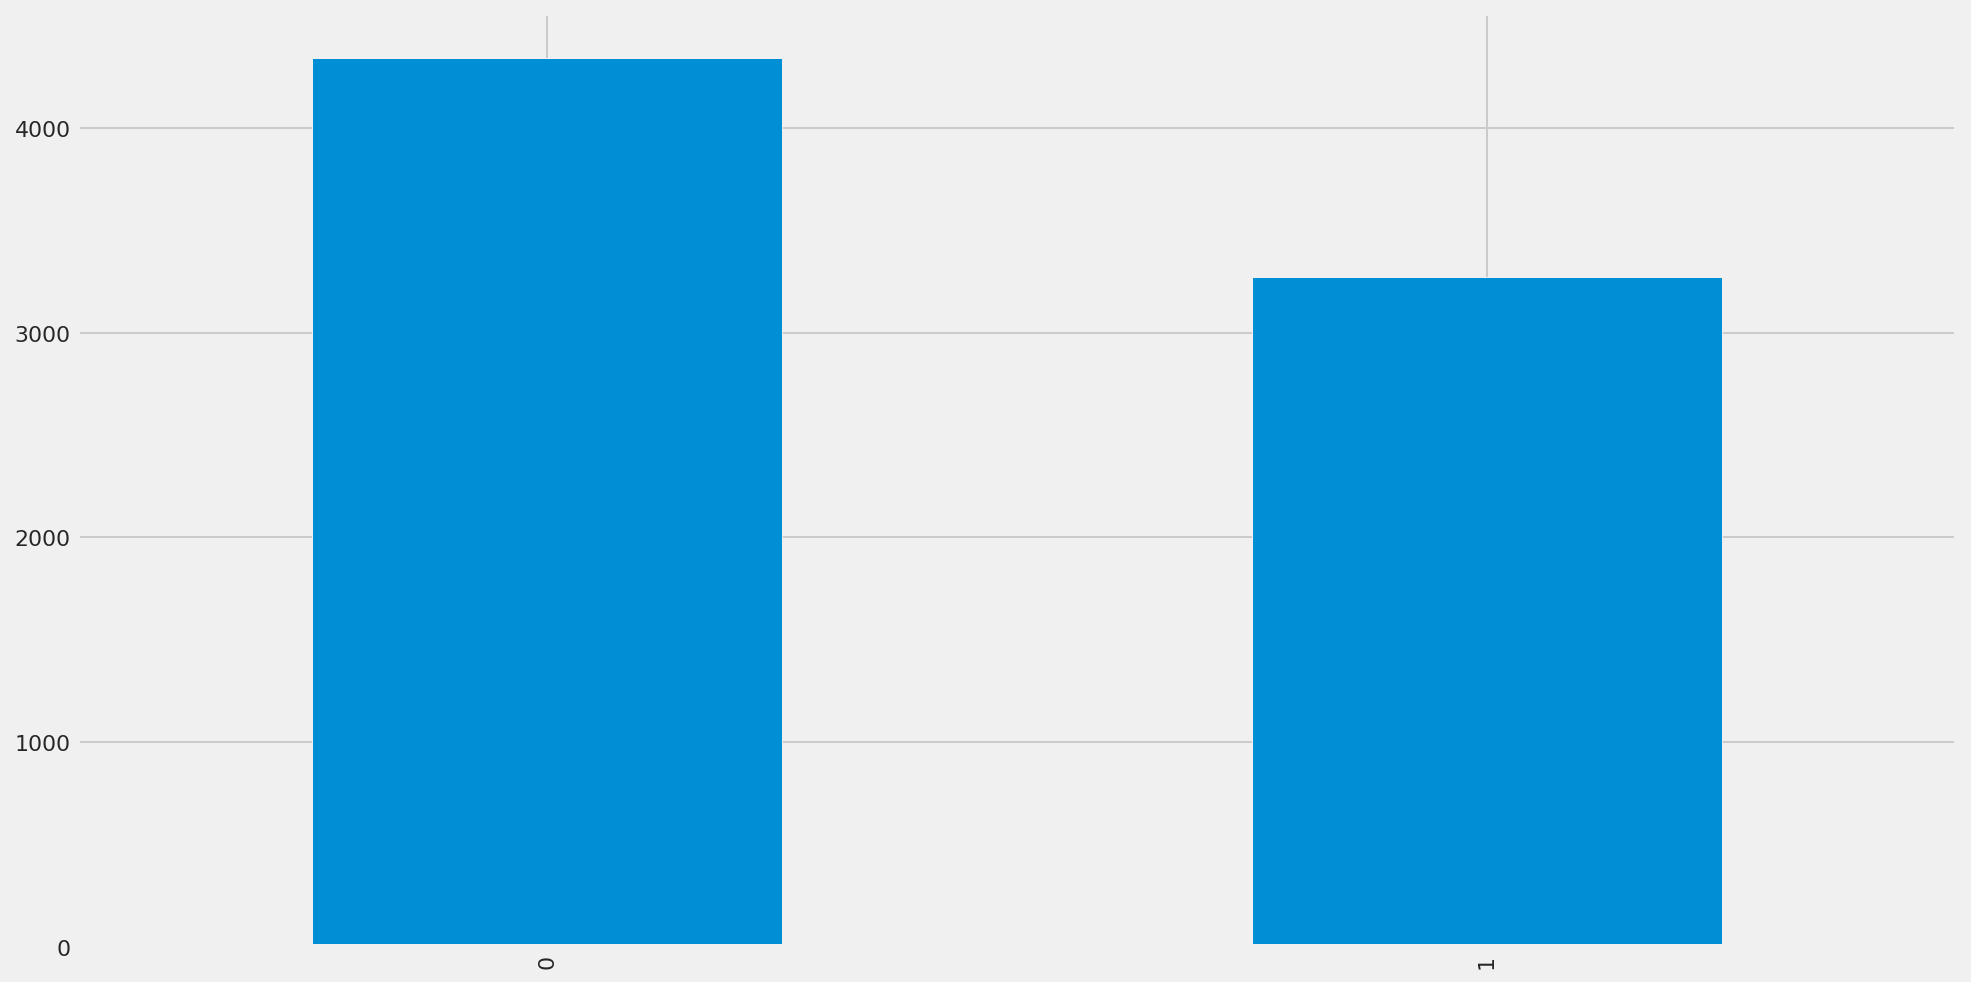

In [106]:
df['target'].value_counts().plot(kind='bar')

## Data Cleansing

In [206]:
# Remove URLs

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

full['text']=full['text'].apply(lambda x : remove_URL(x))

In [207]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

full['text']= full['text'].apply(lambda x : remove_html(x))

In [208]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

full['text']= full['text'].apply(lambda x : remove_emoji(x))

In [110]:
## created a piece to spell correct, but it takes way too long to do


#%%time 
#
#spell = SpellChecker(tokenizer=True)
#
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)
#
#
#df['text'][:50].apply(lambda x : correct_spellings(x))

## Create Corpus 

In [111]:
!spacy download en_core_web_sm

2021-10-06 11:44:17.923922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 11:44:17.924014: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 7.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [209]:
nlp = spacy.load("en_core_web_sm")

In [210]:
%%time
full['tokenized'] = full['text'].apply(nlp)

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


In [211]:
# should split up, removes stop words, punctuation, useless words and lemmatizes

full['tokenized_clean'] = full['tokenized'].apply(lambda doc: ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct
                                                                   and not token.pos_=='X']))

In [212]:
%%time
full['sent_vectors'] = full['tokenized'].apply(lambda doc: np.mean([token.vector for token in doc]))

CPU times: user 593 ms, sys: 0 ns, total: 593 ms
Wall time: 592 ms


In [213]:
full['char_len'] = full['tokenized_clean'].apply(lambda x: len(x))
full['word_len'] = full['tokenized_clean'].apply(lambda x: len(x.split()))

In [214]:
corpus = []
for text in full['tokenized_clean']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)

num_words = len(corpus)
print(num_words)

10876


In [216]:
max_len = 32
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

word_index = tokenizer.word_index

print(f'Number of unique words: {len(word_index)}')

Number of unique words: 19834


In [217]:
num_words=len(word_index)+1

In [25]:
# Source: https://zenodo.org/record/3237458#.YVws_UbMK3J
# Original Source: https://github.com/stanfordnlp/GloVe

embedding = {}
with open("../data/input/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

print(f"Number of words in embedding file: {len(embedding)}")

Number of words in embedding file: 1193515


In [218]:
embedding_matrix = np.zeros((num_words+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [219]:
embedding_matrix.shape

(19836, 100)

In [222]:
tweet_pad.shape

(10876, 32)

In [224]:
train = tweet_pad[:df.shape[0]]
test = tweet_pad[df.shape[0]:]

In [226]:
X_train, X_test, y_train, y_test = train_test_split(train, df['target'], test_size=.15, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6471, 32) (6471,)
(1142, 32) (1142,)


## Modelling 

In [227]:
embedding_matrix.shape

(19836, 100)

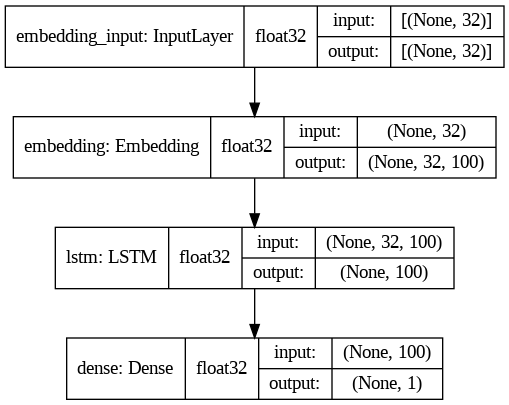

In [240]:
clear_session()
model = Sequential()

embedding_layer = Embedding(input_dim=num_words+1, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False)

model.add(embedding_layer)
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True, show_dtype=True)

In [241]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, 
                    validation_data=(X_test, y_test))

Epoch 1/10
26/26 [==============================] - 4s 111ms/step - loss: 0.5849 - accuracy: 0.6871 - val_loss: 0.4950 - val_accuracy: 0.7968
Epoch 2/10
26/26 [==============================] - 3s 96ms/step - loss: 0.4680 - accuracy: 0.7991 - val_loss: 0.4624 - val_accuracy: 0.7960
Epoch 3/10
26/26 [==============================] - 3s 106ms/step - loss: 0.4499 - accuracy: 0.8042 - val_loss: 0.4588 - val_accuracy: 0.8091
Epoch 4/10
26/26 [==============================] - 2s 93ms/step - loss: 0.4364 - accuracy: 0.8133 - val_loss: 0.4573 - val_accuracy: 0.8082
Epoch 5/10
26/26 [==============================] - 3s 102ms/step - loss: 0.4219 - accuracy: 0.8180 - val_loss: 0.4433 - val_accuracy: 0.8109
Epoch 6/10
26/26 [==============================] - 3s 95ms/step - loss: 0.4114 - accuracy: 0.8214 - val_loss: 0.4433 - val_accuracy: 0.8161
Epoch 7/10
26/26 [==============================] - 3s 99ms/step - loss: 0.4015 - accuracy: 0.8286 - val_loss: 0.4488 - val_accuracy: 0.8047
Epoch 8/10

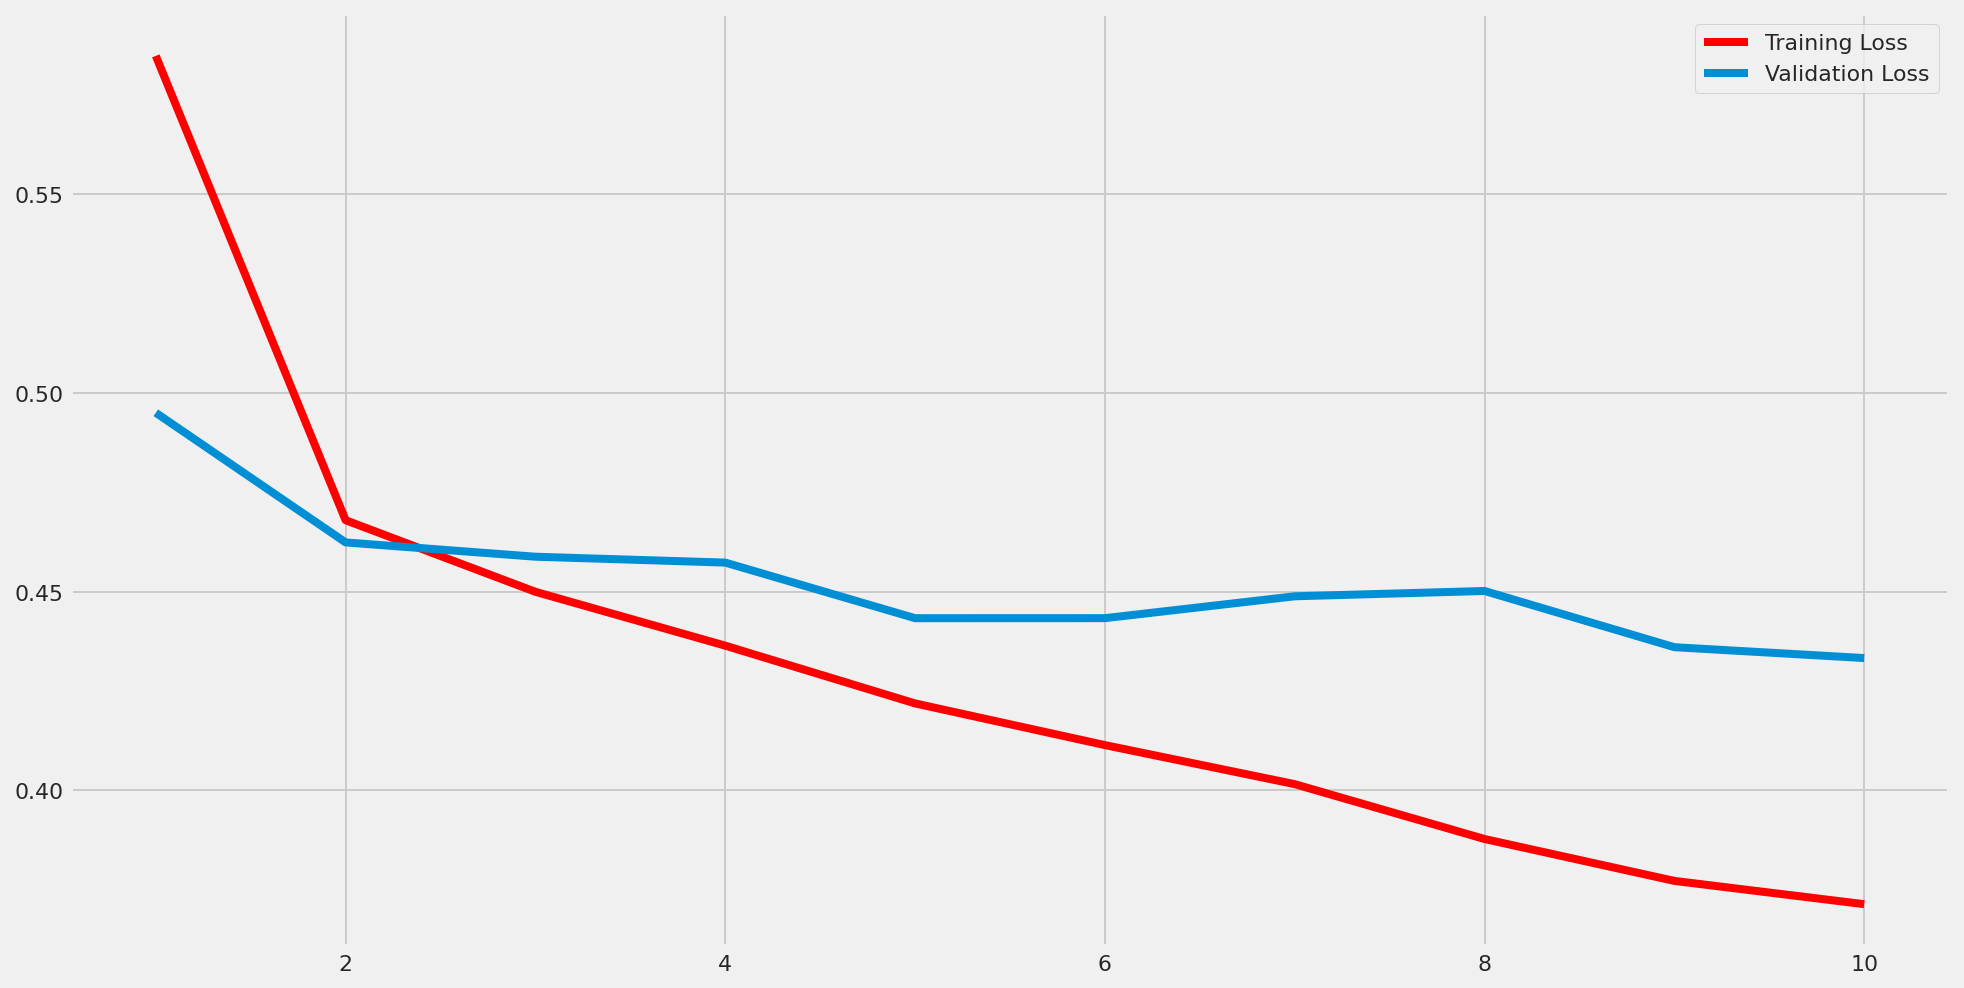

In [242]:
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

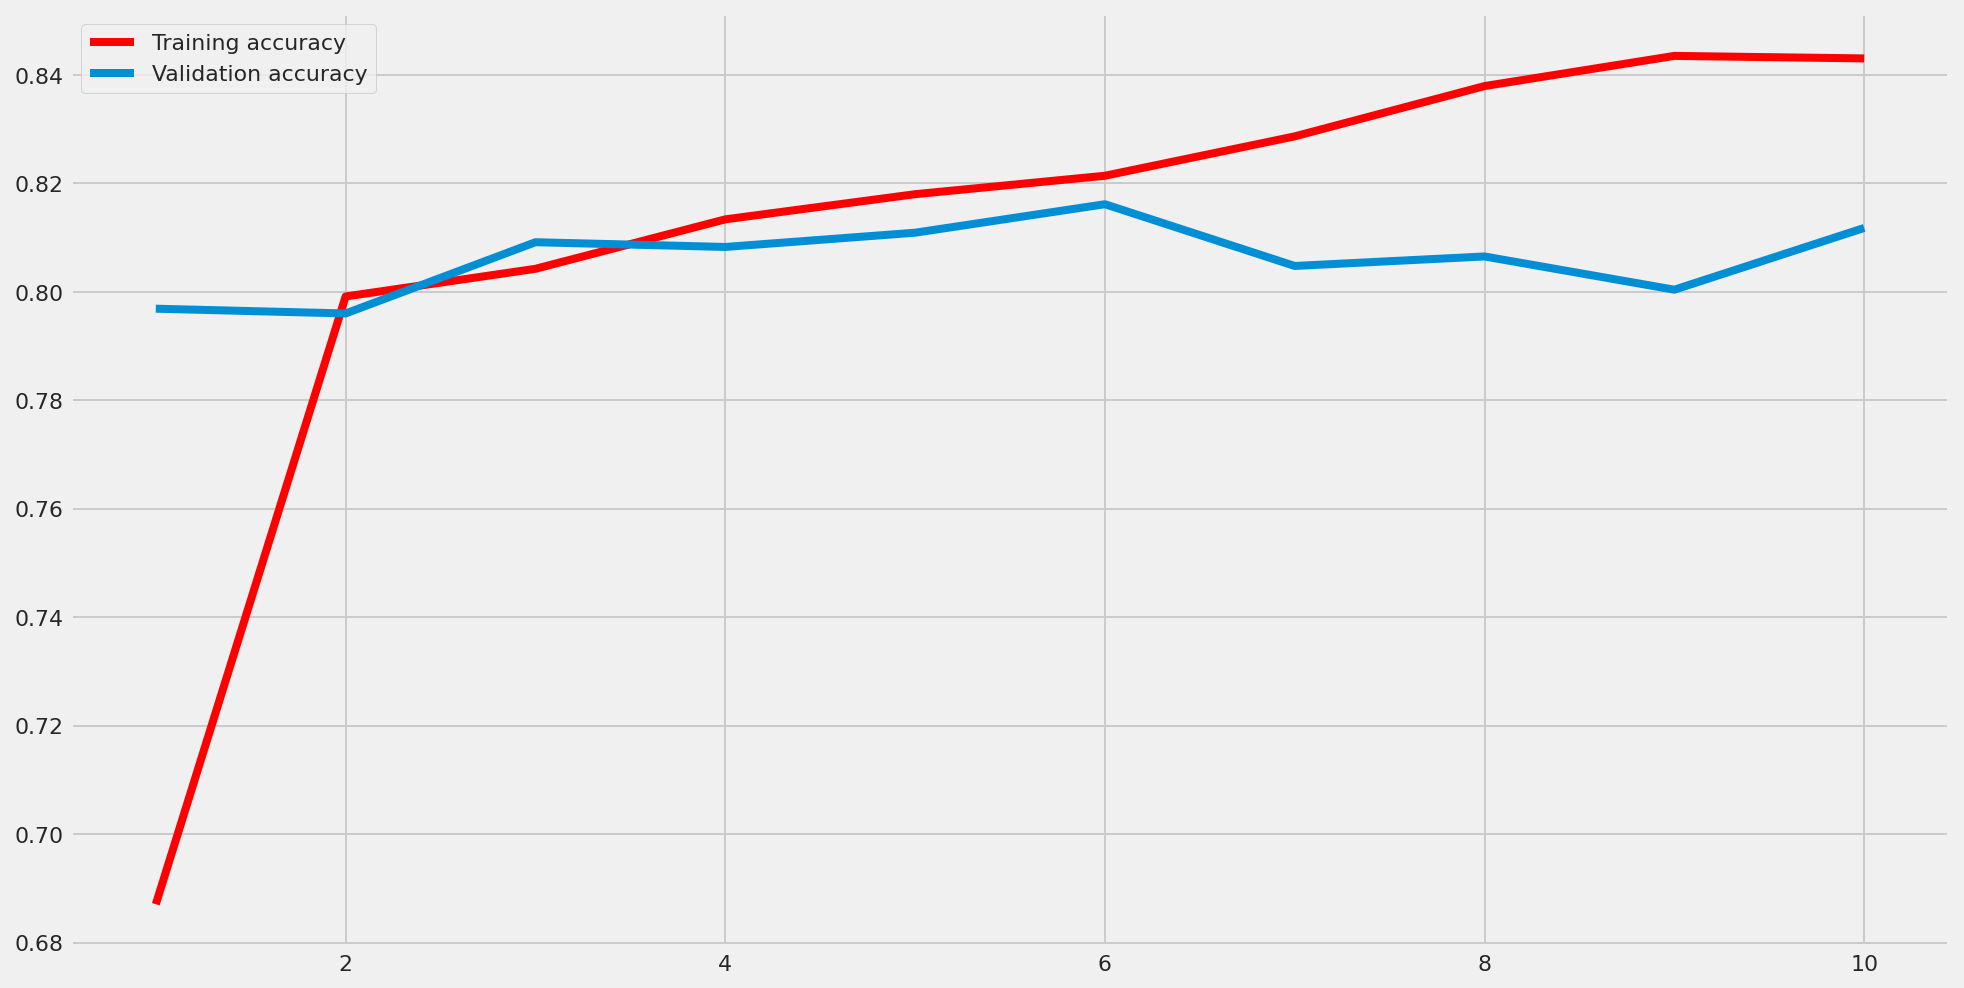

In [243]:
plt.plot(epochs, history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

## Evaluate model

In [248]:
y_pred_test = np.round(model.predict(X_test)).astype('int')

In [250]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       651
           1       0.85      0.68      0.76       491

    accuracy                           0.81      1142
   macro avg       0.82      0.80      0.80      1142
weighted avg       0.82      0.81      0.81      1142



## Prediction time 

In [257]:
test_o

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [254]:
y_pred = np.round(model.predict(test)).astype(int).reshape(test.shape[0])

In [255]:
y_pred

array([1, 1, 1, ..., 1, 0, 0])

In [258]:
test_o['target'] = y_pred

In [259]:
test_o.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [263]:
test_o[['id', 'target']].to_csv(f'../results/submission_{datetime.now().strftime("%Y_%m_%d")}.csv', index=False)